In [4]:
import os, sys
from pathlib import Path

nb_dir = Path.cwd()
repo_root = nb_dir.parent
sys.path.insert(0, str(repo_root))

print("Notebook dir:", nb_dir)
print("Repo root:", repo_root)

Notebook dir: h:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\notebooks
Repo root: h:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion


In [5]:
import os, random
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.geo_constraints import DataPaths
from src.dataset_vie import StanfordVIEWellPatchDataset
from src.models.baseline_geo_cnn import GeoCNNTraceHead

DATA_ROOT = r"H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data"
paths = DataPaths(DATA_ROOT)

constraints_npz = os.path.join(paths.processed_dir, "constraints.npz")
ds = StanfordVIEWellPatchDataset(paths, constraints_npz, patch_hw=4, use_masked_y=True, normalize=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(ckpt_path):
    model = GeoCNNTraceHead(in_channels=7, base=32, t=200).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    return model, ckpt

ckpt_baseline = os.path.join(paths.processed_dir, "checkpoints_baseline", "best.pt")
ckpt_phys     = os.path.join(paths.processed_dir, "checkpoints_physics", "best.pt")
ckpt_wC       = os.path.join(paths.processed_dir, "checkpoints_physics_weightedC", "best.pt")

m0, c0 = load_model(ckpt_baseline)
m1, c1 = load_model(ckpt_phys)
m2, c2 = load_model(ckpt_wC)

print("loaded three checkpoints")

loaded three checkpoints


C:\Users\Windows\AppData\Local\Temp\ipykernel_8204\3414167739.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


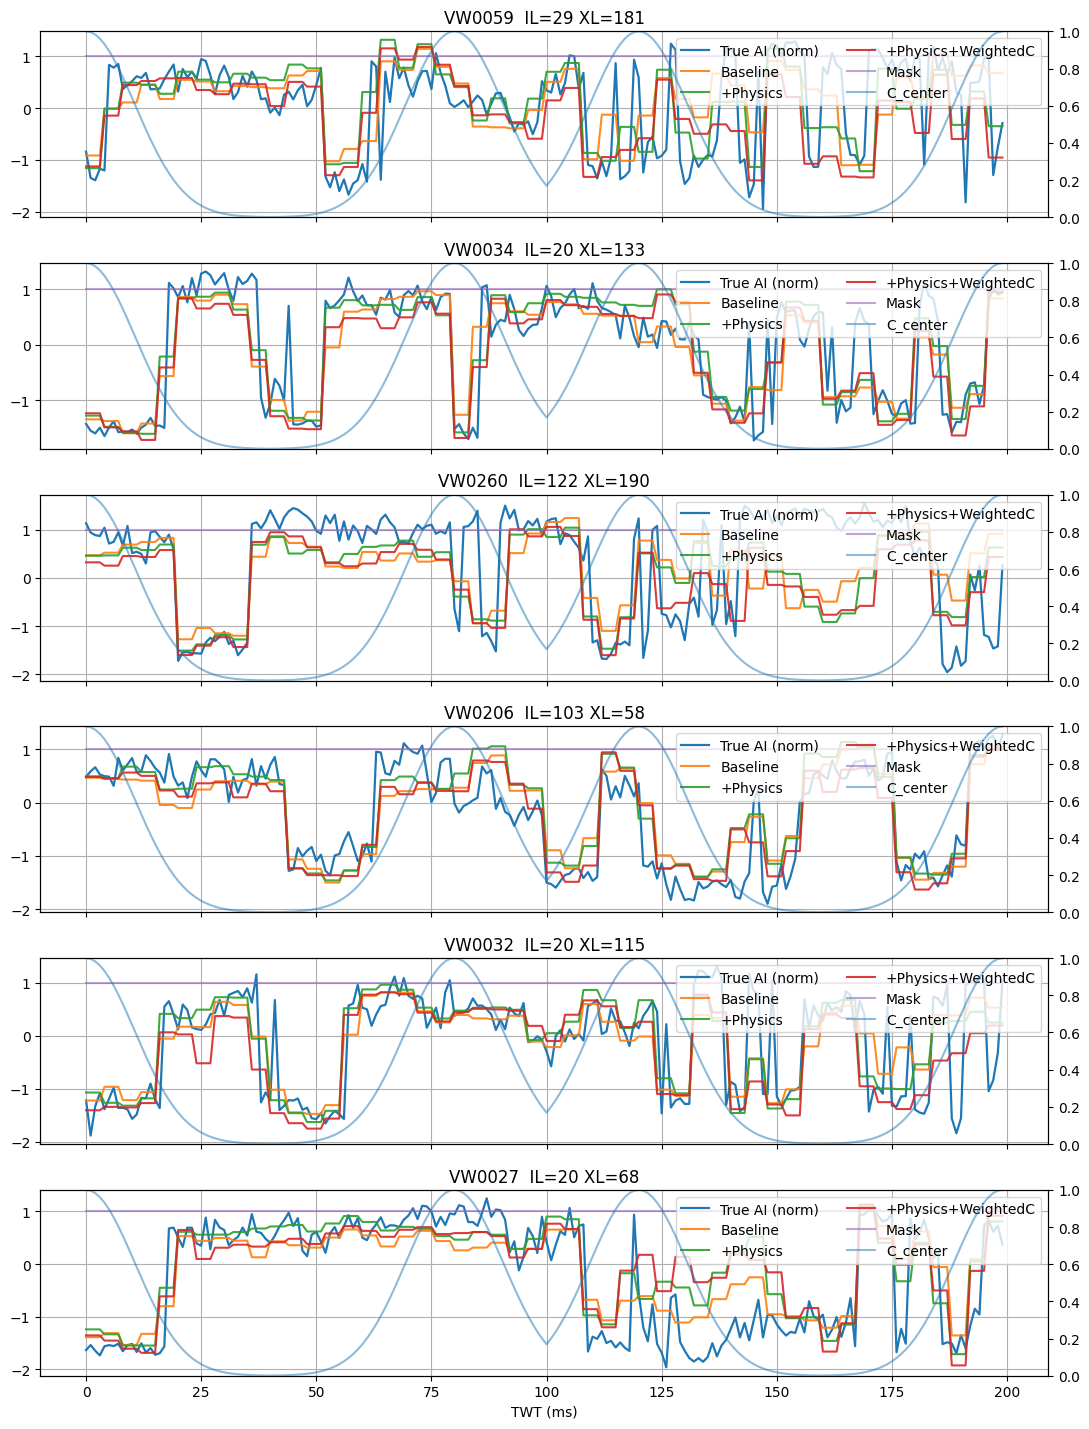

In [6]:
split_dir = os.path.join(paths.processed_dir, "splits")
val_idx = np.load(os.path.join(split_dir, "val_idx.npy"))

random.seed(2026)
show_ids = random.sample(val_idx.tolist(), 6)
t = np.arange(200)

fig, axes = plt.subplots(len(show_ids), 1, figsize=(11, 2.4*len(show_ids)), sharex=True)
if len(show_ids) == 1:
    axes = [axes]

with torch.no_grad():
    for ax, idx in zip(axes, show_ids):
        b = ds[idx]
        x = b["x"][None].to(device)
        p = b["p"][None].to(device)
        c = b["c"][None].to(device)
        m = b["m"][None].to(device)
        y = b["y"].cpu().numpy()

        H = b["m"].shape[1]; W = b["m"].shape[2]
        mc = b["m"][0, H//2, W//2, :].numpy()
        cc = b["c_center"].cpu().numpy()

        y0 = m0(x,p,c,m)[0].cpu().numpy()
        y1 = m1(x,p,c,m)[0].cpu().numpy()
        y2 = m2(x,p,c,m)[0].cpu().numpy()

        ax.plot(t, y,  label="True AI (norm)", linewidth=1.6)
        ax.plot(t, y0, label="Baseline", alpha=0.9)
        ax.plot(t, y1, label="+Physics", alpha=0.9)
        ax.plot(t, y2, label="+Physics+WeightedC", alpha=0.9)
        ax.plot(t, mc, label="Mask", alpha=0.6)

        ax2 = ax.twinx()
        ax2.plot(t, cc, label="C_center", alpha=0.5)
        ax2.set_ylim(0, 1.0)

        ax.set_title(f"{b['wellname']}  IL={int(b['il'])} XL={int(b['xl'])}")
        ax.grid(True)

        # merge legends
        l1, lb1 = ax.get_legend_handles_labels()
        l2, lb2 = ax2.get_legend_handles_labels()
        ax.legend(l1 + l2, lb1 + lb2, loc="upper right", ncol=2)

axes[-1].set_xlabel("TWT (ms)")
plt.tight_layout()
plt.show()